In [200]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [ ]:
# Reference to public kaggle kernels licensed under Apache 2.0 open source license
# Some cells are inspired by the tutorials of Dante, Yassine Ghouzam and LD Freeman

In [201]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# ML algorithms
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier

# Model selection and analysis tools
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint
import itertools
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

In [202]:
train_raw = pd.read_csv("/kaggle/input/titanic/train.csv")
test_raw = pd.read_csv("/kaggle/input/titanic/test.csv")

In [203]:
# Copy Data to clean it
train_data = train_raw.copy()
test_data = test_raw.copy()

# Create List for easy access on both datasets
clean_train_test = [train_data, test_data]

# 1. Data Analysis
Let's have a first look into the DataFrame. 

**Competition Description**

> The sinking of the Titanic is one of the most infamous shipwrecks in history.
>
>On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
>
>The data has been split into two groups:
>
>training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.
>
>The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.
>
>We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower
>
>age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
>
>sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)
>
>parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [204]:
print(train_raw.info())
print(train_raw.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.

**Investigate missing data cells**

Let's search for every cell that has NaN. This will show us how complete the dataset is and what data cells we might need to fill.

In [205]:
# Analyze for missing data

for dataset in clean_train_test:
    print("")
    for key in list(dataset.columns.values):
        gap = pd.isnull(dataset[key]).sum()
        gap_percentage = gap / len(dataset) * 100
        print("{:.1f}% of {} data is missing".format(gap_percentage, key))


0.0% of PassengerId data is missing
0.0% of Survived data is missing
0.0% of Pclass data is missing
0.0% of Name data is missing
0.0% of Sex data is missing
19.9% of Age data is missing
0.0% of SibSp data is missing
0.0% of Parch data is missing
0.0% of Ticket data is missing
0.0% of Fare data is missing
77.1% of Cabin data is missing
0.2% of Embarked data is missing

0.0% of PassengerId data is missing
0.0% of Pclass data is missing
0.0% of Name data is missing
0.0% of Sex data is missing
20.6% of Age data is missing
0.0% of SibSp data is missing
0.0% of Parch data is missing
0.0% of Ticket data is missing
0.2% of Fare data is missing
78.2% of Cabin data is missing
0.0% of Embarked data is missing


For age and cabin data a significant share is missing. We'll see if it is possible to fill these.
For Embarked data and Fare data only few cells are missing. We probably can fill them right away.

In [206]:
train_data.describe(include = 'all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


# 2. Clean Data and Fill Missing Data Gaps

Let's see what info we can extract from the already available features. As there is a lot of social data we will try to get more detailed info on every person and detect their relations to other passengers. 

For the Embarked data we will detect the most commong value and replace the empty cell with it. For the missing Fare cell we will calculate the median value over all cells. 

Additionally we will calculate the family size by adding Parch and SibSp + 1.

For the Cabin Info we will drop the Number and just save the deck (first letter of the cabin) to a new column.

Lastly we detect every passenger that is traveling alone.

In [207]:
# Fill missing data

def cabin_into_deck(x):
    if x['Cabin'][0] == 'T':
        return 'A' #T is even higher than A
    return x['Cabin'][0]

for dataset in clean_train_test:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace = True)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['Cabin'].fillna('X', inplace = True)
    dataset['Deck'] = dataset.apply(cabin_into_deck, axis = 1)


for dataset in clean_train_test:
    dataset.loc[:,'TravAlone'] = 0
    dataset['TravAlone'].loc[dataset['FamilySize'] == 1] = 1

In [208]:
# Create new feature from family size
for dataset in clean_train_test:
    dataset['SmallF'] = dataset['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    dataset['MedF'] = dataset['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    dataset['LargeF'] = dataset['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

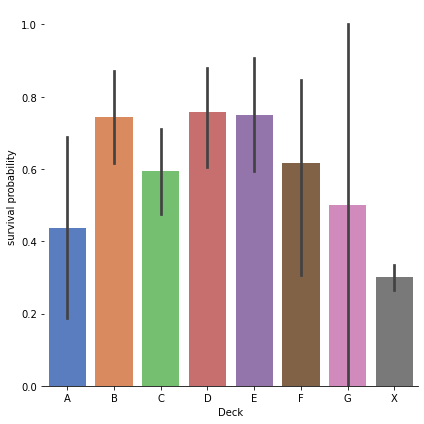

In [209]:
# Group the decks together. A is the highest deck while 
key = 'Deck'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted", order=['A','B','C','D','E','F','G','X'])
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [210]:
for dataset in clean_train_test:
    dataset['Deck_A'] = dataset['Deck'].loc[(dataset['Deck'] == 'A')]
    dataset['Deck_BCDE'] = dataset['Deck'].loc[(dataset['Deck'] == 'B') | (dataset['Deck'] == 'C')
                                               | (dataset['Deck'] == 'D') | (dataset['Deck'] == 'E')]
    dataset['Deck_FG'] = dataset['Deck'].loc[(dataset['Deck'] == 'F') | (dataset['Deck'] == 'G')]
    dataset['Deck_X'] = dataset['Deck'].loc[(dataset['Deck'] == 'X')]

**Fare data**

When looking deeper into the fare data we will realize that families/groups sharing a cabin have the same fare prize in their data cell. Passengers from the third class have similar values to person in the first class. To get more realistic fare prise per person we will detect groups of people sharing a cabin by grouping the dataset by the ticket number. 

Afterwards we will devide the fare price by the group size. This will be safed in a new column "FareCorr".

In [211]:
for dataset in clean_train_test:
    # look for person with the same ticket and divide the fare price by the number of persons
    dataset['FareCorr'] = dataset['Fare'].copy()
    
    for _, grp_df in dataset[['Ticket', 'Fare', 'PassengerId']].groupby(['Ticket']):

        if (len(grp_df) != 1):
            for _, row in grp_df.iterrows():
                passID = row['PassengerId']
                dataset['FareCorr'].loc[dataset['PassengerId'] == passID] = dataset['Fare'][dataset['PassengerId'] 
                                                                                            == passID] / len(grp_df)

To make the data more accessable by our machine learning algoritmn we will thin the dataset to different bins and save it into the new column "FarCat".

In [212]:
for dataset in clean_train_test:
    dataset['FareCat']=pd.cut(dataset['FareCorr'], bins=[0,15,65,max(dataset["FareCorr"]+1)], labels=['low','mid','high'])

In [213]:
# Check if "FareCat" is complete
train_data.loc[train_data['FareCat'].isna() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,TravAlone,SmallF,MedF,LargeF,Deck_A,Deck_BCDE,Deck_FG,Deck_X,FareCorr,FareCat
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,...,1,0,0,0,NaN,B,NaN,NaN,0.0,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,...,1,0,0,0,NaN,NaN,NaN,X,0.0,NaN


Apparently there are some cells with fare data == 0 that were not cut with the bins. Let's put them into "mid" and "low" categories depening on the passenger class. These are either crew members or did somehow get the trip for free. Let's not assume that these compare to high class fare prizes. 

In [214]:
for dataset in clean_train_test:
    dataset['FareCat'].loc[(dataset['FareCat'].isna() == True) & (dataset['Pclass'] == 1)] = 'low'
    dataset['FareCat'].loc[(dataset['FareCat'].isna() == True) & (dataset['Pclass'] > 1)] = 'mid'

**Titles**

The names category give a lot of room for feature engineering. The most obvious is probably extracting the titles. From these titles we will be able to differenciate from younger and older people and maybe from people of higher social class. We will also use these titles later to calculate the median age for different passenger groups. The goals is not to create too many different titles to allow for a better learing as our dataset is limited in size.

In [215]:
# Extract titles from names to get more possible features to learn age

def replace_name_with_title(x):
    """Searches for titles in names and extracts them in a new column Title"""
    
    line = x['Name']
    
    #title_mr = ['Mr', 'Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']
    title_mr = ['Mr']
    title_mrs = ['Mrs', 'Mme']
    title_miss = ['Miss', 'Mlle', 'Ms']
    title_others = ['Sir','Don','Dona','Jonkheer','Lady','Countess','Dr', 'Rev','Col','Major','Capt']
    
    for title in title_others:
        if title in line:
            return 'Other'
    
    for title in title_mrs:
        if title in line:
            return 'Mrs'
        
    for title in title_mr:
        if title in line:
            return 'Mr'
        
    if 'Master' in line:
        return 'Master'
        
    for title in title_miss:
        if title in line:
            return 'Miss'
        
    return np.nan

for dataset in clean_train_test:
    
    #df = dataset.copy()      
    dataset['Title'] = dataset.apply(replace_name_with_title, axis=1) 
    
print(train_data['Title'].value_counts())
print(train_data['Title'].isna().sum())

Mr        506
Miss      180
Mrs       127
Master     40
Other      38
Name: Title, dtype: int64
0


Let's see how these median age claculations compare. Also as there is no equivalent for "Master" we will split the title "Miss" into "Young Miss" (travels with parents) and "Miss" (travels without parents and children).

In [216]:
def print_mean_age():
    # Calculate mean age values for different titles
    print('Mr')
    print(train_data['Age'].loc[train_data['Title'] == 'Mr'].median())
    print('Master')
    print(train_data['Age'].loc[train_data['Title'] == 'Master'].median())
    print('Mrs')
    print(train_data['Age'].loc[train_data['Title'] == 'Mrs'].median())
    print('Young Miss')
    print(train_data['Age'].loc[(train_data['Title'] == 'Miss') & (train_data['Parch'] != 0) & (train_data['Age'] < 15)].median())
    print('Miss')
    print(train_data['Age'].loc[(train_data['Title'] == 'Miss') & (train_data['Parch'] == 0)].median())
    print('Other')
    print(train_data['Age'].loc[train_data['Title'] == 'Other'].median())
    
print_mean_age()

Mr
29.5
Master
3.5
Mrs
35.0
Young Miss
4.0
Miss
26.0
Other
40.0


We can clearly see that "Young Miss" and "Miss" have very different age medians. Therefore we will proceed and create a new title called "Young Miss".

In [217]:
for dataset in clean_train_test:

    # Fill missing age value with mean values according to title
    mean_age_mr = dataset['Age'].loc[dataset['Title'] == 'Mr'].median()
    mean_age_master = dataset['Age'].loc[dataset['Title'] == 'Master'].median()
    mean_age_mrs = dataset['Age'].loc[dataset['Title'] == 'Mrs'].median()
    mean_age_miss = dataset['Age'].loc[dataset['Title'] == 'Miss'].median()
    mean_age_youngmiss = dataset['Age'].loc[(dataset['Title'] == 'Miss') & (dataset['Parch'] != 0)
                                           & (dataset['Age'] < 15)].median()
    mean_age_other = dataset['Age'].loc[dataset['Title'] == 'Other'].median()
    
    dataset['Title'].loc[(dataset['Title'] == 'Miss') & (dataset['Parch'] != 0)] = 'YoungMiss'
    
    print(mean_age_mr,mean_age_master,mean_age_mrs,mean_age_miss, mean_age_youngmiss, mean_age_other)
    
    dataset['Age'].loc[(dataset['Title'] == 'Mr') & (dataset['Age'].isna() == True)]  = mean_age_mr
    dataset['Age'].loc[(dataset['Title'] == 'Master') & (dataset['Age'].isna() == True)] = mean_age_master
    dataset['Age'].loc[(dataset['Title'] == 'Mrs') & (dataset['Age'].isna() == True)] =  mean_age_mrs
    dataset['Age'].loc[(dataset['Title'] == 'Miss') & (dataset['Age'].isna() == True)]  = mean_age_miss
    dataset['Age'].loc[(dataset['Title'] == 'YoungMiss') & (dataset['Age'].isna() == True)] = mean_age_youngmiss
    dataset['Age'].loc[(dataset['Title'] == 'Other') & (dataset['Age'].isna() == True)] =  mean_age_other


29.5 3.5 35.0 21.0 4.0 40.0
29.0 6.5 36.0 22.0 2.0 39.0


We all know the rule "Women and Children First". It's probably reasonable that women and children have a higher chance of survival. We will extract an additional label "Child" from all the female and male passengers. I guess that it doesn't really matter if the child is male or female. We will later check if that feature give more insight than sex alone.

In [218]:
for dataset in clean_train_test:
    
    dataset['MFK'] = dataset['Sex']
    dataset['MFK'].loc[dataset['Age'] <15] = 'Child'

Let's also thin out the "Age" feature 5 different age groups. This will probably speed up our Machine Learning Algorithm.

In [219]:
for dataset in clean_train_test:
    dataset["AgeCat"]= pd.cut(dataset["Age"], bins=[0,14.9,30,45,60,max(dataset["Age"]+1)], labels=['1','2','3','4','5'])

As the feature "Pclass" is not continous we will save it into three different features.

In [220]:
for dataset in clean_train_test:
    
    dataset['Pclass_1'] = dataset['Pclass'].loc[dataset['Pclass'] == 1]
    dataset['Pclass_1'].fillna(0, inplace = True)
    dataset['Pclass_2'] = dataset['Pclass'].loc[dataset['Pclass'] == 2] / 2
    dataset['Pclass_2'].fillna(0, inplace = True)
    dataset['Pclass_3'] = dataset['Pclass'].loc[dataset['Pclass'] == 3] / 3
    dataset['Pclass_3'].fillna(0, inplace = True)


**Family Survival**

This is a long shot and might be seen as a little hack. It is only possible because our training and test set will not be growing over time. The thinking behind this is that families probably stay together and if they made it to a rescue ship they probably all lifed. We will detect families in both datasets and group them together. So let's add them together with concat.

Afterwards we will check if a majority of the family survied and put the "Family Survival" to 1. If the majority dies we will put 0. If we are unsure (the majority is in the test set where the label survival is not set) we will put it to 0.5.

In [222]:
data = pd.concat([train_data, test_data], axis=0, ignore_index=True, sort=True)
    
# Extract the last name. 
data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])

# Set a default value for all passengers
data['FamilySurvival'] = 0.5

# Group by Last Name
for _, grp_df in data[['Survived', 'Last_Name', 'Ticket', 'PassengerId']].groupby(['Last_Name']):

    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data['FamilySurvival'].loc[data['PassengerId'] == passID] = 1
            elif (smin == 0.0):
                data['FamilySurvival'].loc[data['PassengerId'] == passID] = 0

#Group by ticket
for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        #print(grp_df)
        for ind, row in grp_df.iterrows():
            if (row['FamilySurvival'] == 0) | (row['FamilySurvival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data['FamilySurvival'].loc[data['PassengerId'] == passID] = 1
                elif (smin == 0.0):
                    data['FamilySurvival'].loc[data['PassengerId'] == passID] = 0

# Check number of passengers in the different categories
data['FamilySurvival'].value_counts() 

0.5    656
1.0    376
0.0    277
Name: FamilySurvival, dtype: int64

Now we need to get this info back into our train and test dataframes. Let's map them by PassengerID.

In [223]:
for dataset in clean_train_test:
    dataset['FamilySurvival'] = 0.5

for dataset in clean_train_test:
    for passid in range(int(dataset['PassengerId'][0]), int(dataset['PassengerId'][-1:])+1):
        dataset['FamilySurvival'].loc[dataset['PassengerId'] == passid] = float(data[
            'FamilySurvival'].loc[data['PassengerId'] == passid])

    print(dataset['FamilySurvival'].value_counts())

0.5    453
1.0    251
0.0    187
Name: FamilySurvival, dtype: int64
0.5    203
1.0    125
0.0     90
Name: FamilySurvival, dtype: int64


Again we will create three different features for 1, 0.5 and 0 to help our ML algortihm.

In [ ]:
for dataset in clean_train_test:
    
    dataset['FamilySurvival_1'] = dataset['FamilySurvival'].loc[dataset['FamilySurvival'] == 1.0]
    dataset['FamilySurvival_1'].fillna(0,inplace = True)
    dataset['FamilySurvival_0.5'] = dataset['FamilySurvival'].loc[dataset['FamilySurvival'] == 0.5] +0.5
    dataset['FamilySurvival_0.5'].fillna(0,inplace = True)
    dataset['FamilySurvival_0'] = dataset['FamilySurvival'].loc[dataset['FamilySurvival'] == 0] +1
    dataset['FamilySurvival_0'].fillna(0,inplace = True)

In [ ]:
# Analyze for missing data

for dataset in clean_train_test:
    print("")
    for key in list(dataset.columns.values):
        gap = pd.isnull(dataset[key]).sum()
        gap_percentage = gap / len(dataset) * 100
        print("{:.1f}% of {} data is missing".format(gap_percentage, key))

# 3. Feature Analysis

In this section we will dive deeper into each existing and engineered feature to decide which to keep and which to drop.

In [ ]:
#Subset of all available features
features = list(train_data.columns.values)
features.remove('Survived')

for key in features:

    if train_data[key].dtype != 'float64' :
        print('Survival rate for feature "{}"'.format(key))
        print(train_data.groupby(key, as_index=True).mean()['Survived'])
        print('----')
        print('')

In [ ]:
key = 'Pclass'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [ ]:
key = 'FamilySurvival'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

This works better than expected. It seems that family survival is indeed a thing.

In [ ]:
key = 'Title'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

"Women and children first" and maybe some nobles

In [ ]:
key = 'FamilySize'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [ ]:
g = sns.factorplot(x="SmallF",y="Survived",data=train_data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=train_data,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=train_data,kind="bar")
g = g.set_ylabels("Survival Probability")

This shows significant differences. Let prioritize it over "Family Size"

In [ ]:
key = 'TravAlone'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [ ]:
key = 'Embarked'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [ ]:
key = 'Sex'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [ ]:
key = 'MFK'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

I like how the children give more value. Also cuts alot of young males out of the picture. Let's drop "Sex" for this.

In [ ]:
key = 'SibSp'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [ ]:
key = 'Parch'

# Explore SibSp feature vs Survived
g = sns.factorplot(x=key,y="Survived",data=train_data,kind="bar", size = 6 , 
                   palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

In [ ]:
# Explore Age vs Survived
g = sns.FacetGrid(train_data, col='Survived')
g = g.map(sns.distplot, "Age")

In [ ]:
# Explore Age distibution 
g = sns.kdeplot(train_data["Age"][(train_data["Survived"] == 0)], color="Red", shade = True)
g = sns.kdeplot(train_data["Age"][(train_data["Survived"] == 1)], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [ ]:
# Explore Age vs Survived
g = sns.FacetGrid(train_data, col='Survived')
g = g.map(sns.distplot, "Fare")

In [ ]:
for dataset in clean_train_test:

    # Apply log to Fare to reduce skewness distribution
    dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
    

In [ ]:
# Explore Age distibution 
g = sns.kdeplot(train_data["Fare"][(train_data["Survived"] == 0)], color="Red", shade = True)
g = sns.kdeplot(train_data["Fare"][(train_data["Survived"] == 1)], ax =g, color="Blue", shade= True)
g.set_xlabel("Fare")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

**Features selection**

Let's see what features have built up and think about what we want to keep and what to drop.

In [ ]:
features = list(train_data.columns.values)
features.remove('Survived')
print(features)

In [ ]:
plt.figure(figsize = (15,10))
g = sns.heatmap(dataset[features].corr(),cmap="BrBG",annot=True, square=True, )

In [ ]:
# Drop features that didn't make the cut.
features.remove('PassengerId')
features.remove('Name')
features.remove('Parch')
features.remove('SibSp')
features.remove('FamilySize')
#features.remove('SmallF')
#features.remove('MedF')
#features.remove('LargeF')
features.remove('Cabin')
features.remove('Ticket')
features.remove('FareCorr')
features.remove('Fare')
features.remove('Deck')
features.remove('Age')
features.remove('Sex')
features.remove('Pclass') 
features.remove('FamilySurvival') 
#features.remove('MFK') 
features.remove('Deck_X')
features.remove('Deck_A')


print(features)

This is our final list of features. I tuned this list quite alot and tries alot of different versions. Finally I stayed with this set.

# 4. Model Analysis and Hyperparameter Tuning

In [ ]:
#normalization of big values to range of 10
def normalization(col, n=1):
    """Normalized whole column. Takes col pandas series. n is the range"""
    
    col=((col-col.min())/(col.max()-col.min()))*n
    return col

for dataset in clean_train_test:
    dataset['Age'] = normalization(dataset['Age'],1)
    dataset['Fare'] = normalization(dataset['Fare'],1)
    dataset['FareCorr'] = normalization(dataset['FareCorr'],1)

In [ ]:
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])
y = train_data["Survived"]

print('X and X_Test shape')
print(X.shape)
print(X_test.shape)

if list(X.columns.values) == list(X_test.columns.values):
    print('Features in both datasets match.')
else:
    print('Features in both datasets do not match.')

#split the train data
train1_x, test1_x, train1_y, test1_y = train_test_split(X, y, random_state = 0)

print('Test and Validation shape from train_test_split of X')
print(train1_x.shape)
print(train1_y.shape)
print(test1_x.shape)
print(test1_y.shape)

In [ ]:
X

PCA to reduce dimenson to 2 for plotting

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_)
#print(pca.components_)

X_trans = pca.fit_transform(X)
print(X.shape)
print(X_trans.shape)
type(X_trans)

plt.scatter(X_trans[:, 0], X_trans[:, 1],c=y, cmap='rainbow')

5.2 Model Selection

In [ ]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [ ]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X, y = y, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree",
                                                                                      "AdaBoost",
                                                                                      "RandomForest",
                                                                                      "ExtraTrees",
                                                                                      "GradientBoosting",
                                                                                      "MultipleLayerPerceptron",
                                                                                      "KNeighboors",
                                                                                      "LogisticRegression",
                                                                                      "LinearDiscriminantAnalysis",
                                                                                      "XGBClassifier"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

Let's choose some ML algortims from this list to do some hyperparameter tuning. 

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],  #['rbf', 'linear','poly', 'sigmoid']
                  'gamma': [0.01, 0.02, 0.03, 0.05], #[ 0.001, 0.01, 0.1, 1]
                  'C': [1, 10, 50, 100, 200]} #[1, 10, 50, 100,200,300, 1000]

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, n_jobs= 4, verbose = 1, return_train_score=True, refit=True)

gsSVMC.fit(X,y)

SVMC_best = gsSVMC.best_estimator_

# Best score
print(gsSVMC.best_score_)
print(gsSVMC.best_params_)


#{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

In [ ]:
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X,y,cv=kfold)

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [50, 100, 200, 300],
              'learning_rate': [0.001, 0.01, 0.05, 1],
              'max_depth': [4, 5],
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X,y)

GBC_best = gsGBC.best_estimator_

# Best score
print(gsGBC.best_score_)
print(gsGBC.best_params_)

In [ ]:
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X,y,cv=kfold)

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [5,6,7],
              "max_features": ['auto'],
              
               }

            #"min_samples_split": [3,10,15],
           #   "min_samples_leaf": [18, 20, 22],
            #  "bootstrap": [False],
            #  "n_estimators" :[80, 100, 120],

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X,y)

RFC_best = gsRFC.best_estimator_

# Best score
print(gsRFC.best_score_)
print(gsRFC.best_params_)

#best_params_{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 
#'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

In [ ]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X,y,cv=kfold)

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None, 3, 4, 5],
              "max_features": ['auto', 10, 30],}
              #"min_samples_split": [2, 4],
              #"min_samples_leaf": [1, 5],
              #"bootstrap": [False],
              #"n_estimators" :[200],
              #"criterion": ["gini", "entropy"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X,y)

ExtC_best = gsExtC.best_estimator_

# Best score
print(gsExtC.best_score_)
print(gsExtC.best_params_)

In [ ]:
g = plot_learning_curve(gsExtC.best_estimator_,"Extra Tree mearning curves",X,y,cv=kfold)


In [ ]:
#LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()


## Search grid for optimal parameters
ex_param_grid = {"solver": ['svd,''lsqr', 'eigen'],
              "shrinkage": ['auto', None],
              "n_components": [None, 1, 10, 100],
              }


gsLDA = GridSearchCV(LDA,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsLDA.fit(X,y)

LDA_best = gsLDA.best_estimator_

# Best score
print(gsLDA.best_score_)
print(gsLDA.best_params_)

In [ ]:
g = plot_learning_curve(gsLDA.best_estimator_,"Linear Disciminant Analysis mearning curves",X,y,cv=kfold)

# 5. Esembly

In [ ]:
votingC = VotingClassifier(estimators=[('gbc',GBC_best), ('extc', ExtC_best),
('svc', SVMC_best),  ('rfc', RFC_best), ('LDA', LDA_best)], voting='soft', n_jobs=4)  # ('gbc',GBC_best),

#SVMC_best
#GBC_best
#RFC_best
#LREG_best
#ExtC_best

votingC = votingC.fit(X, y)

In the end Gradient Boost Clasifier did outperform all others and even did better than the esembly. So let's keep it.

In [ ]:
#model = SVC(probability= True, C= 100, gamma= 0.01, kernel= 'rbf')
#model = RandomForestClassifier(bootstrap=False, max_depth=5, max_features='auto',
#                               min_samples_leaf=4,min_samples_split=10,n_estimators=150)

#model.fit(X,y)

predictions = gsGBC.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission_version34.csv', index=False)
print("Your submission was successfully saved!")